# Density-based clustering

Notebook for the density-based clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import procyclingstats as pcs
# Base libraries
import os
import sys
# Basic data manipulation libraries
import numpy as np
import pandas as pd
import itertools
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import umap

import scipy.stats as stats
# Clustering related imports
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))



In [3]:
IMAGES_DIR = os.path.join('Images', 'Clustering_imgs', 'density_based_imgs')

Imports from our utilities

In [4]:
from utility.overall_utilities import save_plot
from utility.plotting_utilities import plot_kdistances
from utility.cluster_utility import scale_data, DBSCAN_grid_search#, hier_search, get_average_cyclist_per_cluster


Other constants, global variables

In [5]:
# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = False

### Dataframes

Now let's read the datasets!

In [6]:
cyclist_df = pd.read_csv(os.path.join('..','dataset','cyclists_cleaned.csv'))
races_df = pd.read_csv(os.path.join('..','dataset','races_cleaned.csv'))

In [7]:
print("cyclist_df columns:")
print(cyclist_df.columns)
print()
print("races_df columns:")
print(races_df.columns)

cyclist_df columns:
Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist',
       'cyclist_age', 'mean_stamina_index'],
      dtype='object')

races_df columns:
Index(['_url', 'name', 'stage', 'stage_type', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age', 'is_tarmac', 'delta', 'time', 'time_seconds',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'norm_points', 'age_performance_index', 'quality_adjusted_points',
       'normalized_length', 'normalized_quality', 'normalized_steepness',
       'normalized_time', 'stamina_index'],
      dtype='object')


## Cyclists clustering

Let's start with the cyclists and see where it brings us

### Choosing the data, dropping columns

In [8]:
cyclist_df.dtypes

_url                    object
name                    object
birth_year             float64
weight                 float64
height                 float64
nationality             object
bmi                    float64
race_count             float64
experience_level        object
total_points           float64
victories_by_points      int64
avg_points_per_race    float64
average_position       float64
avg_speed_cyclist      float64
cyclist_age            float64
mean_stamina_index     float64
dtype: object

Although starting with a more loose analysis, there are some columns to drop:
- All the non-numerical columns. These are better kept as labels, or to "probe" the result
- The `bmi`, `cyclist_age` and `avg_points_per_race`, because they're a function of other features
- The `weight` column, because it's strongly correlated with the `height` column and the latter has less missing values

In [9]:
# Remove all the non-numeric columns
cyclist_clustering_df = cyclist_df.select_dtypes(include=[np.number])
# Remove features derived from other two
cyclist_clustering_df.drop(columns=['bmi','avg_points_per_race','weight','cyclist_age'], inplace=True)
cyclist_clustering_df.dtypes

birth_year             float64
height                 float64
race_count             float64
total_points           float64
victories_by_points      int64
average_position       float64
avg_speed_cyclist      float64
mean_stamina_index     float64
dtype: object

Let's get rid of the records that have missing values

**TODO**: Think about imputation of the ages? We can retrieve it from the races dataframe...

In [10]:
cyclist_clustering_df.isna().sum()

birth_year               13
height                 2991
race_count                0
total_points              0
victories_by_points       0
average_position         39
avg_speed_cyclist        40
mean_stamina_index     1449
dtype: int64

In [11]:
cyclist_clustering_df[cyclist_clustering_df['height'].isna()].isna().sum()

birth_year               13
height                 2991
race_count                0
total_points              0
victories_by_points       0
average_position         23
avg_speed_cyclist        24
mean_stamina_index     1277
dtype: int64

By dropping the rows with missing values we're deleting the cyclists with missing weight, basically. We're also removing some cyclists that do have the weight but don't have the `mean_stamina_index`. The fact that they don't have a value for the `mean_stamina_index` may be due to the fact that they don't have a value for `speed`, or `time`, or anything really.

`mean_stamina_index` is computed as the average of the `stamina_index`, a feature of a cyclist in a race. So if all the rows that correspond to a cyclist are removed from the races dataset (maybe because of the values of `average_speed`, or `delta`, as we've seen during the feature engineering part), then we have nothing to compute the mean of, and we're left with a NaN.

In [12]:
initial_count = cyclist_clustering_df.shape[0]
cyclist_clustering_df.dropna(inplace=True)
final_count = cyclist_clustering_df.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100:2.2f}%')
print(f'Final shape: {cyclist_clustering_df.shape}')

Dropped 3163 rows with missing values
In percentage: 51.57%
Final shape: (2971, 8)


Let's keep in mind that we may suffer from the problem of curse of dimensionality

### Data Normalization

I want to publicly thank DavideB for providing the normalizer of the data.

In [13]:
cyc_clustering_normalizer, cyc_clustering_normalized = scale_data(cyclist_clustering_df)

In [14]:
cyc_clustering_normalized_df = pd.DataFrame(cyc_clustering_normalized).rename(columns={i:col for i,col in enumerate(cyclist_clustering_df.columns)})
cyc_clustering_normalized_df.head()

,birth_year,height,race_count,total_points,victories_by_points,average_position,avg_speed_cyclist,mean_stamina_index
0,-1.622186,0.333190,0.357490,0.594886,-0.195418,-0.794681,-0.284820,0.217862
1,0.995463,1.418614,-0.656951,-0.376406,-0.195418,0.116899,0.972576,-0.254924
2,0.911023,1.883796,-0.000203,-0.196259,-0.195418,-0.032353,0.654576,-0.190979
3,1.079903,-1.372477,-0.662815,-0.417690,-0.195418,-0.573242,0.575466,-0.426411
4,1.164344,-0.442113,-0.909096,-0.413186,-0.195418,-0.239788,-0.856002,0.127241


In [15]:
cyc_clustering_normalized_df.max()


birth_year              1.670985
height                  3.744523
race_count              4.679126
total_points           13.634513
victories_by_points    18.205719
average_position        4.508690
avg_speed_cyclist       6.169188
mean_stamina_index     27.168442
dtype: float64

### Hyperparameters, in general

The key hyperparameters in DBscan are:
- The distance measure $d$
- The `eps` parameter ($\epsilon$), the radius parameter that defines the neighbourhood of a point
- The `min_samples` parameter, that determines how many neighbours a point must have in order to be considered a core point

DBscan is a slow algorithm to run. It's important to choose the hyperparameters wisely. 
- For now, we leave the euclidean distance, hoping for the best
- The `min_samples` hyperparameter:
	- The original article sets it to 4
	- There's an heuristic method proposed by the creators of GDBSCAN 
		> Sander, Jörg, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. “Density-Based Clustering in Spatial Databases: The Algorithm GDBSCAN and Its Applications.” Data Mining and Knowledge Discovery 2, no. 2 (June 1, 1998): 169–94. https://doi.org/10.1023/A:1009745219419.
		
		Which is to set `min_samples = 2*n_cols -1`
	- ***Spasticate autistiche con logaritmi e la densità definita come n° punti fratto volume dell'ellissoide che più o meno li contiene?**
- The `eps` hyperparameter is chosen with the knee method, once the `min_samples` is chosen

### Attempt 1

Let's do a first grid search and discussion

#### Hyperparameters range

So, based on the previous considerations and on manual attempts, we set the hyperparameters search space as follows:
- Distance: just the euclidean distance (for now?)
- `min_samples`: on our first attempt, we consider evenly spaced value in the log space, that is, values from 2 to 128, increasing exponentially. 
- `eps`: one value of $\epsilon$ corresponding to each value of `min_samples`, found using the knee method

In [16]:
MIN_SAMPLES_TRIALS = 8
distance_range = ['euclidean']
min_samples_range = [2**x for x in range(1,MIN_SAMPLES_TRIALS)]
eps_range = [[2], [2.3], [2.5], [3], [3.4], [3.8], [4.2]]

print(f"Values for min_samples: {min_samples_range}")

Values for min_samples: [2, 4, 8, 16, 32, 64, 128]


In [17]:
from scipy.spatial.distance import pdist, squareform

dist = pdist(cyc_clustering_normalized_df, metric=distance_range[0]) # pairwise distances
print(f"dist.shape = {dist.shape}")
dist = squareform(dist) # convert to a distance matrix
print(f"dist.shape = {dist.shape}, cyc_clustering_normalized_df.shape[0] = {cyc_clustering_normalized_df.shape[0]}")

dist.shape = (4411935,)
dist.shape = (2971, 2971), cyc_clustering_normalized_df.shape[0] = 2971


Now let's look at the results visually

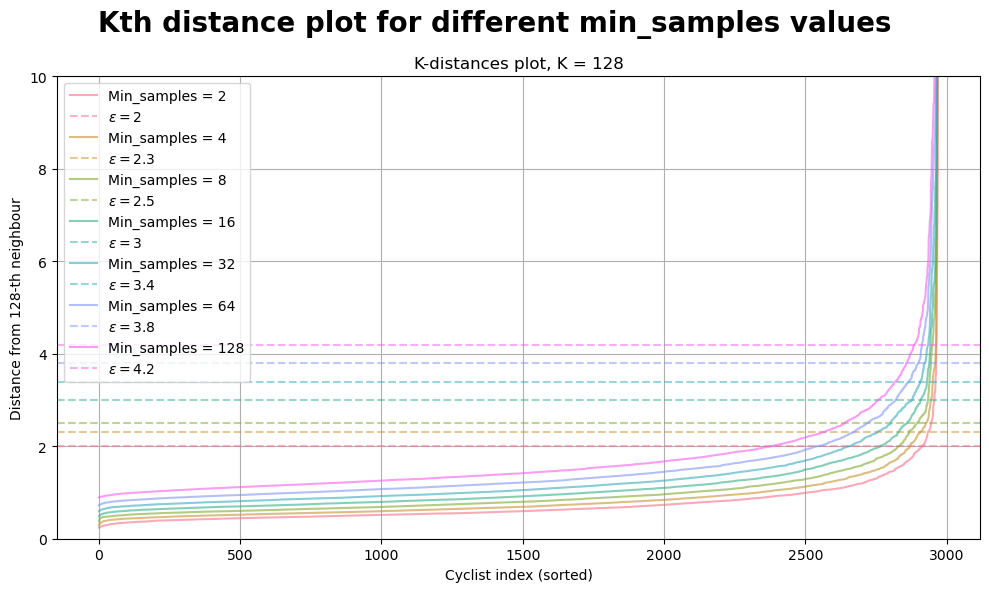

In [18]:
ylim = 10

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Kth distance plot for different min_samples values', fontsize=20, fontweight='bold')
plt.title(f"Restricted view to distances below {ylim}", fontsize=14)

palette = sns.color_palette("husl", len(min_samples_range))
for i, k in enumerate(min_samples_range):
	plot_kdistances(dist_matrix=dist,
				 	k=k, eps_values=eps_range[i],
					color=palette[i], ax=ax, y_lim=ylim)

plt.tight_layout()
plt.show()
	

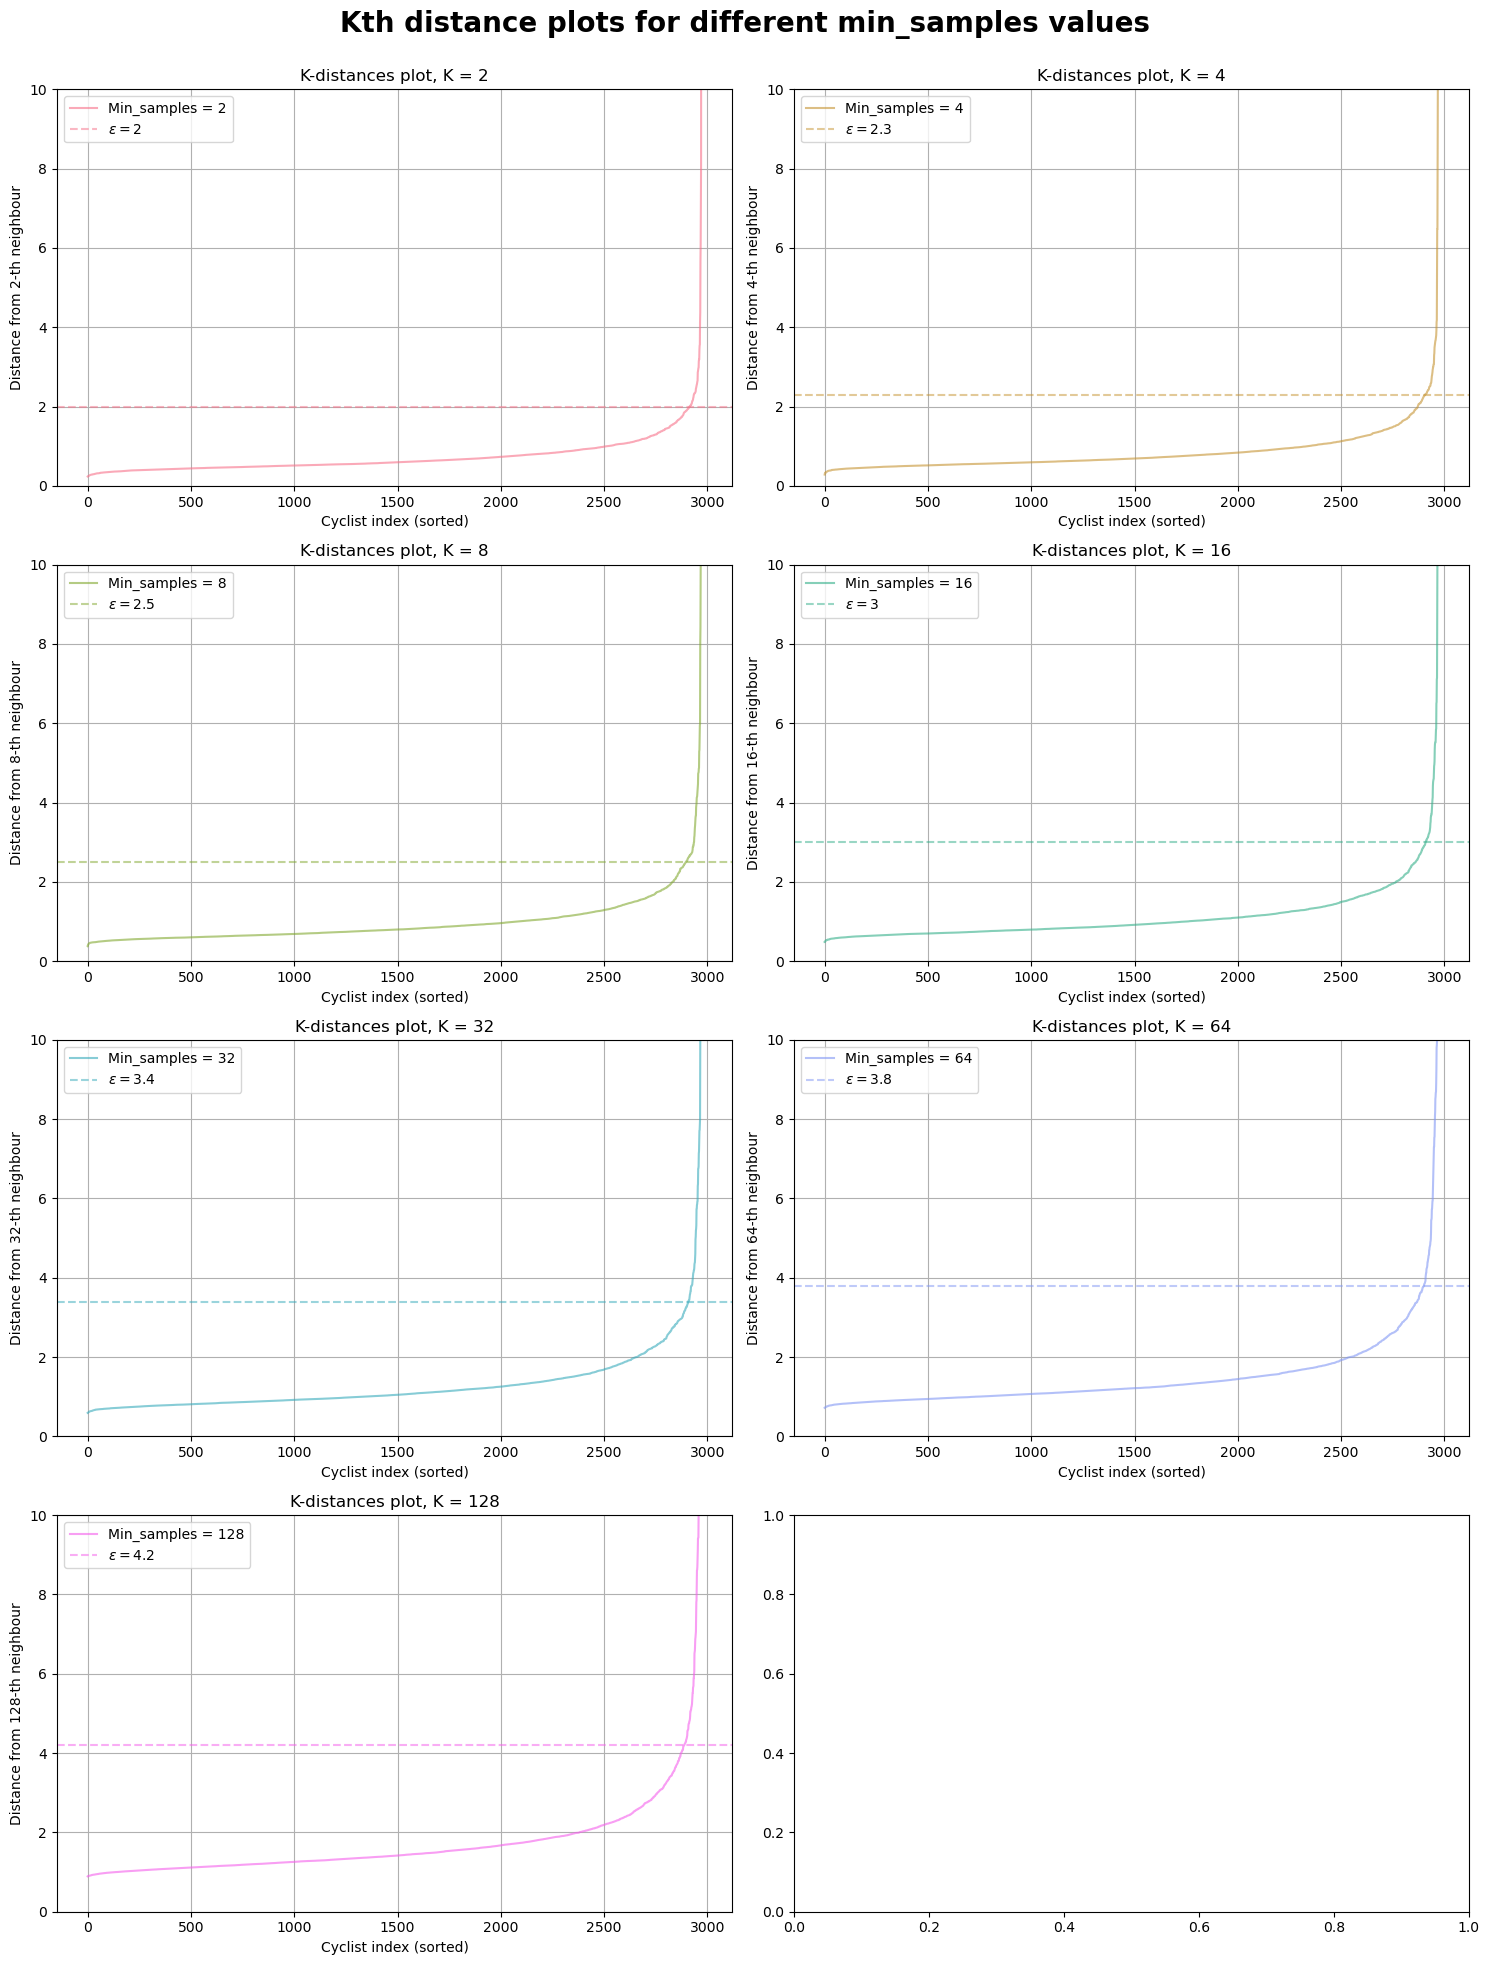

In [19]:
fig, axes = plt.subplots(int(np.ceil(len(min_samples_range) / 2)), 2, figsize=(15, 5 * int(np.ceil(len(min_samples_range) / 2))))
fig.suptitle('Kth distance plots for different min_samples values', fontsize=20, fontweight='bold')
axes = axes.flatten()

palette = sns.color_palette("husl", len(min_samples_range))
for i, (ax, k) in enumerate(zip(axes, min_samples_range)):
	plot_kdistances(dist_matrix=dist,
				 	k=k, ax=ax,
					color=palette[i],
					eps_values=eps_range[i], y_lim=ylim)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Based on the plots, the values for $\epsilon$ have been picked by hand. We notice that the `min_samples` value doesn't look to make that much of a difference, for what concerns the distance with the neighbour

#### Grid search

Now that the hyperparameters have been defined, let's run the algorithm with the different combinations!

In [20]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 2  , min_samples =   2, n_clusters =  3, n_noise =  36, noise % = 1.21, Silhouette score: 0.680
eps = 2.3, min_samples =   4, n_clusters =  3, n_noise =  30, noise % = 1.01, Silhouette score: 0.630
eps = 2.5, min_samples =   8, n_clusters =  1, n_noise =  32, noise % = 1.08, Silhouette score: 0.734
eps = 3  , min_samples =  16, n_clusters =  1, n_noise =  29, noise % = 0.98, Silhouette score: 0.741
eps = 3.4, min_samples =  32, n_clusters =  1, n_noise =  28, noise % = 0.94, Silhouette score: 0.743
eps = 3.8, min_samples =  64, n_clusters =  1, n_noise =  31, noise % = 1.04, Silhouette score: 0.738
eps = 4.2, min_samples = 128, n_clusters =  1, n_noise =  29, noise % = 0.98, Silhouette score: 0.743


We can observe that for `min_samples` values higher than 16 we have the same number of clusters (1, which is really trivial), the same number of noise points (give or take. Of course they decrease as `min_sample` increases) and also the plot of the distances between the points and the kth neighbour look identical (in fact, the values for `eps` are really close). Therefore we just consider the result we get for 16 and then restrict the grid search range.

Furthermore, we notice - even though is obvious - that with a single cluster as the n° of noise points decreases, the silhouette score increases.

In [ ]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=16_eps=3']
print(cyclist_clustering_df['cluster'].value_counts())
print(f"Noise points are {100*sum(cyclist_clustering_df['cluster'] == -1)/cyclist_clustering_df.shape[0]:2.2f}% of the total")

cluster
 0    2942
-1      29
Name: count, dtype: int64
Noise points are 0.98% of the total


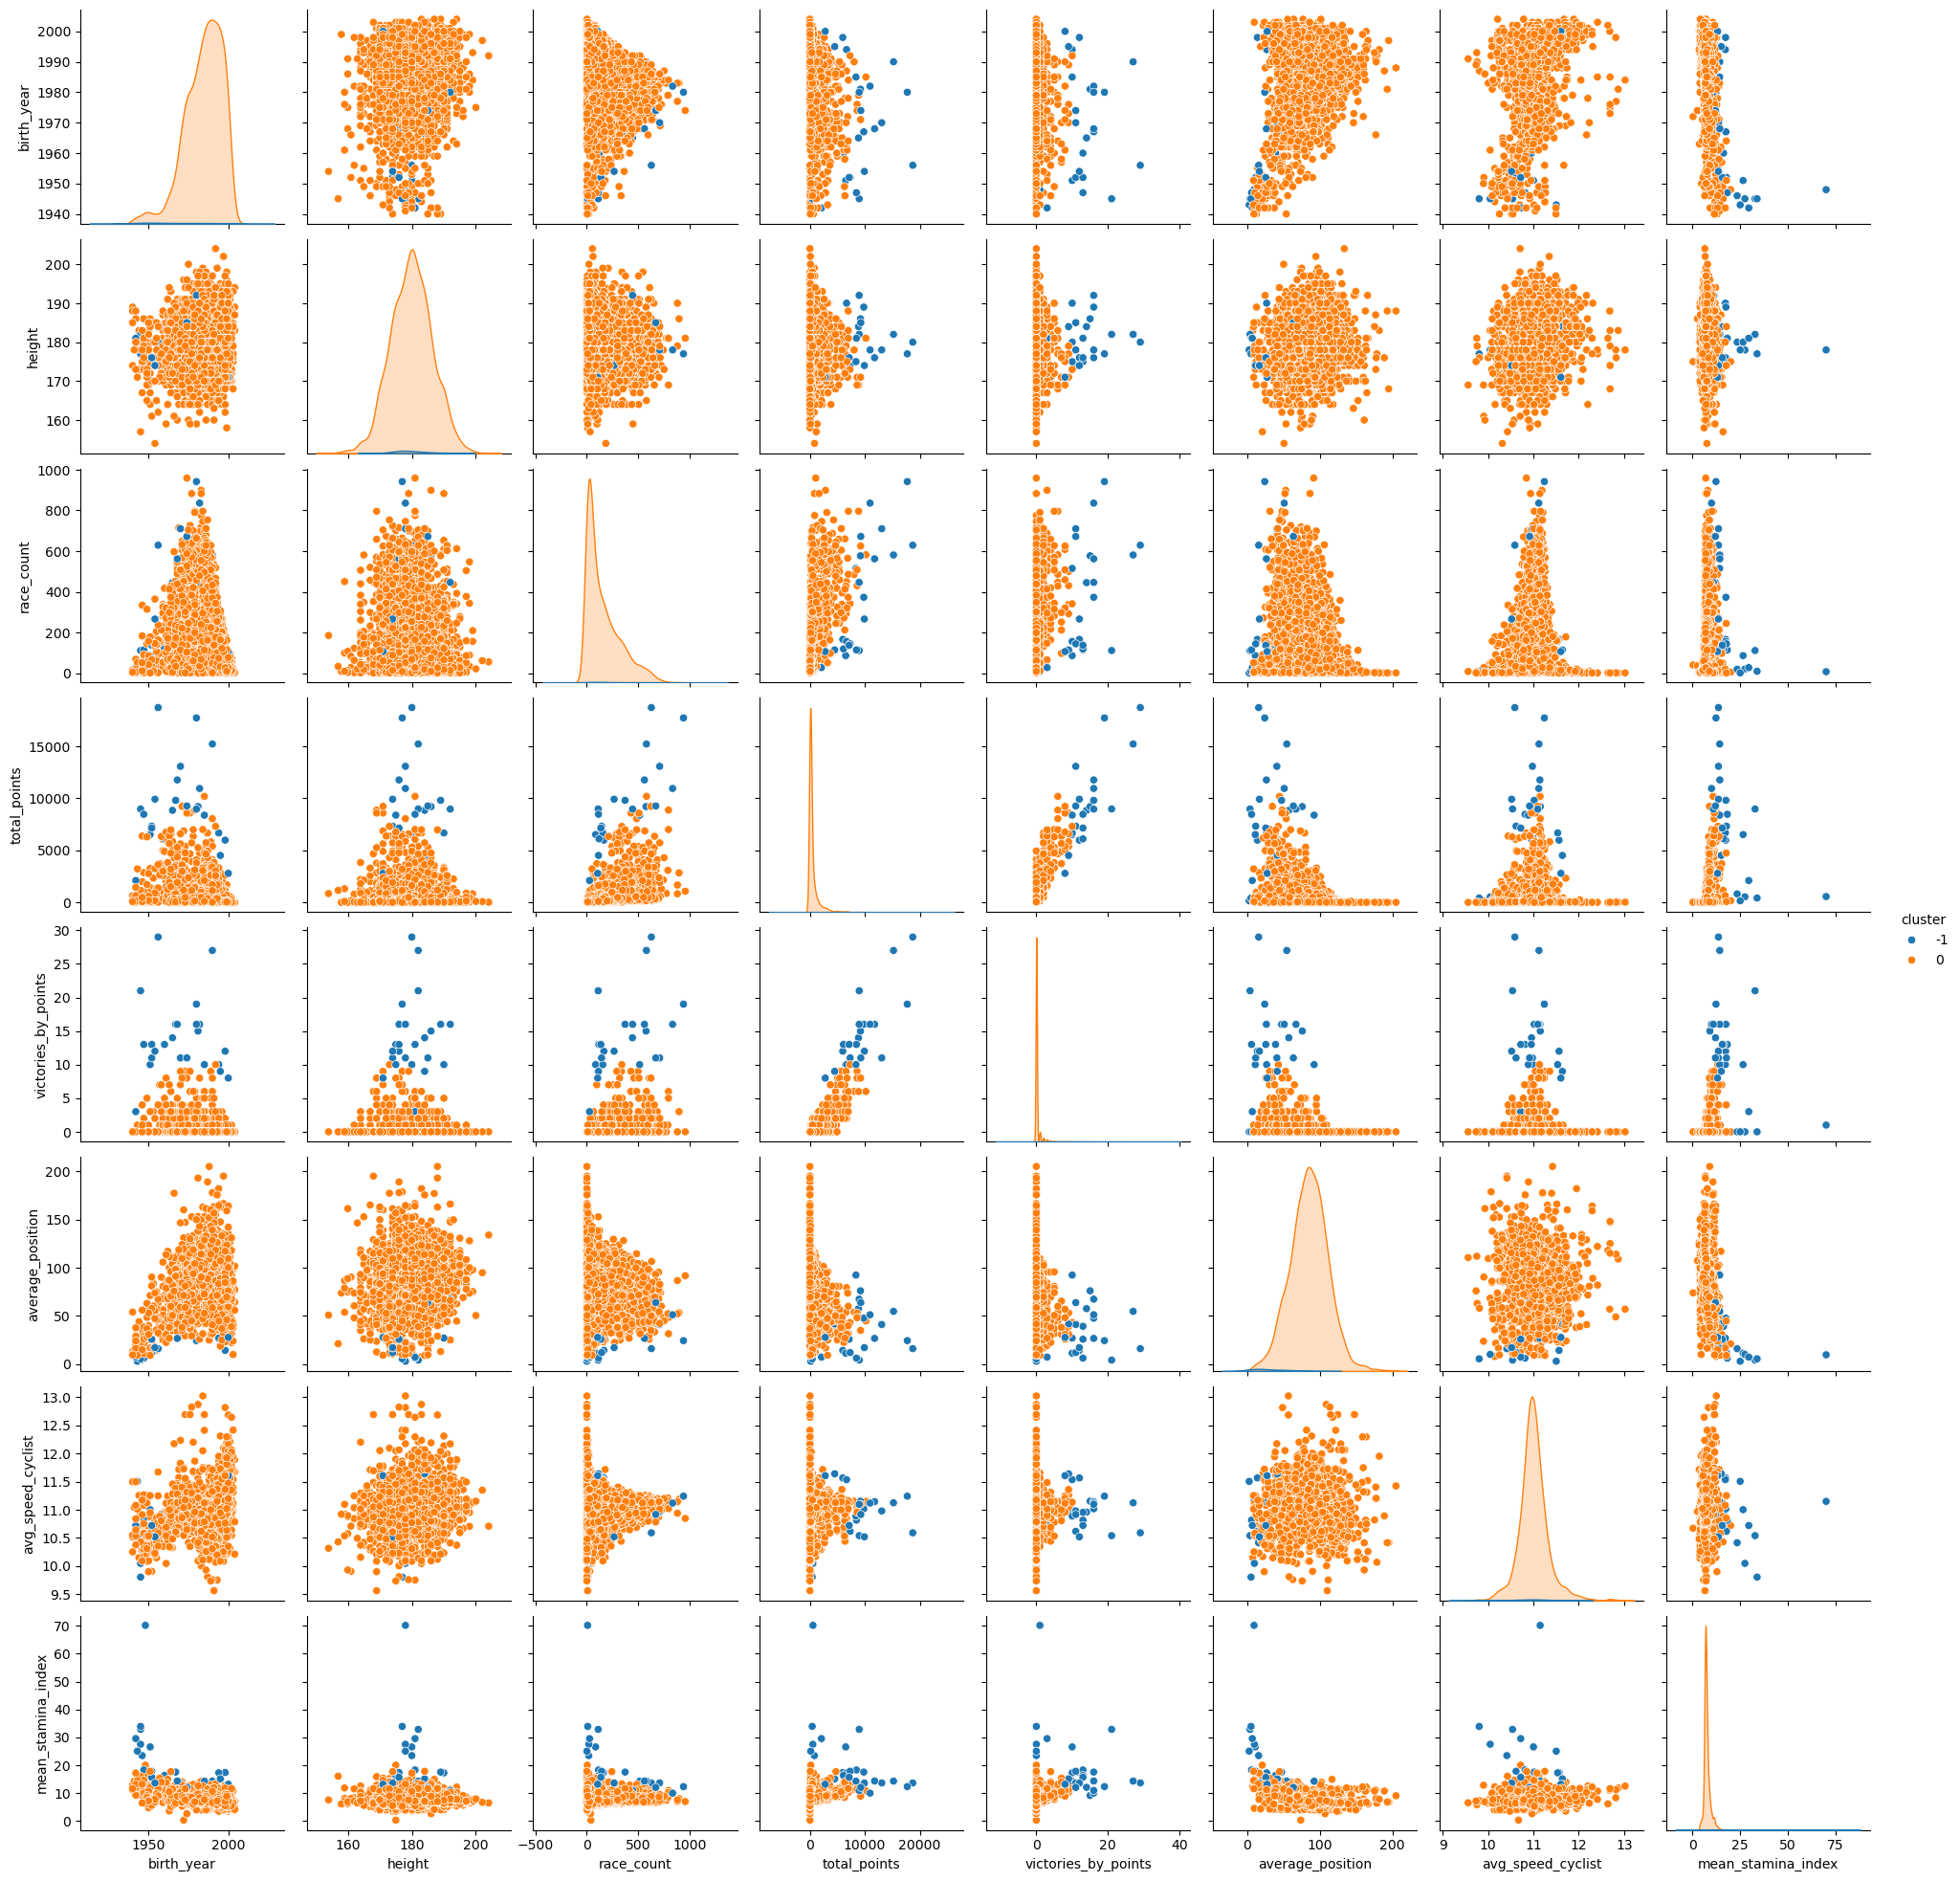

In [22]:
sns.pairplot(cyclist_clustering_df, hue='cluster', palette='tab10')
plt.show()

The fact that there is only one cluster isn't good, and makes this result unsatisfactory, but we can take away from this the noise points, that look reasonable by eye. Let's take a closer look.

In [23]:
noisy_df = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'] == -1].index].drop(columns=['experience_level','cyclist_age'])
noisy_df

,_url,name,birth_year,weight,height,nationality,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
109,tadej-pogacar,Tadej Pogačar,1998.0,66.0,176.0,Slovenia,21.306818,166.0,5980.0,12,36.024096,14.295858,11.565382,17.392149
226,jean-pierre-monsere,Jean-Pierre Monseré,1948.0,66.0,178.0,Belgium,20.830703,7.0,559.0,1,79.857143,9.714286,11.149136,70.167143
418,johan-museeuw,Johan Museeuw,1965.0,71.0,184.0,Belgium,20.971172,445.0,8844.0,14,19.874157,57.549889,10.958454,12.082170
427,eddy-merckx,Eddy Merckx,1945.0,74.0,182.0,Belgium,22.340297,111.0,8976.0,21,80.864865,4.189189,10.539823,32.855248
738,leif-mortensen,Leif Mortensen,1946.0,70.0,180.0,Denmark,21.604938,19.0,814.0,0,42.842105,16.000000,10.414386,23.456878
960,francesco-moser,Francesco Moser,1951.0,79.0,180.0,Italy,24.382716,86.0,6517.0,10,75.779070,11.360465,11.000983,26.568255
992,roger-de-vlaeminck,Roger De Vlaeminck,1947.0,74.0,181.0,Belgium,22.587833,114.0,8465.0,13,74.254386,6.252174,10.815050,18.300479
1175,wout-van-aert,Wout van Aert,1994.0,78.0,190.0,Belgium,21.606648,156.0,6674.0,10,42.782051,27.044025,11.534875,17.274734
1478,luis-ocana,Luis Ocaña,1945.0,NaN,178.0,Spain,NaN,20.0,531.0,0,26.550000,10.100000,10.047702,27.522936
1613,sean-kelly,Sean Kelly,1956.0,77.0,180.0,Ireland,23.765432,629.0,18726.0,29,29.771065,16.067717,10.590556,13.652149


In [24]:
noisy_df.describe()

,birth_year,weight,height,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
count,29.000000,28.000000,29.000000,28.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,1966.034483,71.821429,179.896552,22.152822,306.551724,7617.241379,11.586207,42.401604,30.949344,10.943946,19.593168
std,19.002787,6.104361,5.059255,1.331584,282.517330,4957.554485,7.409055,29.892966,24.223950,0.437423,11.851056
min,1942.000000,61.000000,171.000000,19.470778,1.000000,150.000000,0.000000,13.095694,3.000000,9.803852,9.153238
25%,1948.000000,66.000000,176.000000,21.306818,106.000000,4511.000000,9.000000,20.096413,11.360465,10.720673,13.611124
50%,1965.000000,71.500000,178.000000,21.935362,156.000000,8382.000000,12.000000,36.024096,25.850000,10.978655,15.662663
75%,1981.000000,77.250000,182.000000,23.153996,562.000000,9807.000000,16.000000,51.294118,47.636842,11.149136,23.456878
max,2000.000000,82.000000,192.000000,25.216253,942.000000,18726.000000,29.000000,150.000000,92.355805,11.638725,70.167143


- The `victories_by_points` (and the names! Merckx, Evenpoel, Petacchi, Cipollini, Boonen, Valverde, ...) that there are great champions in here
- By looking at the `avg_points_per_race` and `race_count` features, we can see that on average they participated to a lot of races, gaining many points at each, even though there's great variability. The values of the means for these two features are out of distribution
- Even for what concerns the `average_position` they're on the "elite", i.e. the lower end of the values

All in all, the noisy points that were found look promising

In [25]:
cyclist_clustering_df.drop(columns=['cluster'], inplace=True)

### Attempt 2

Let's speed up. Given the previous considerations on the `min_samples` values, we restrict the search to smaller values for this hyperparameter

#### Hyperparameters range

In [26]:
MIN_SAMPLES_TRIALS = 8
distance_range = ['euclidean']
min_samples_range = [2*x for x in range(1,MIN_SAMPLES_TRIALS)]
eps_range = [[2], [2.3], [2.4], [2.5], [2.6], [2.7], [2.8]]

print(f"Values for min_samples: {min_samples_range}")

Values for min_samples: [2, 4, 6, 8, 10, 12, 14]


Let's look for the $\epsilon$ values (we can keep some from before)

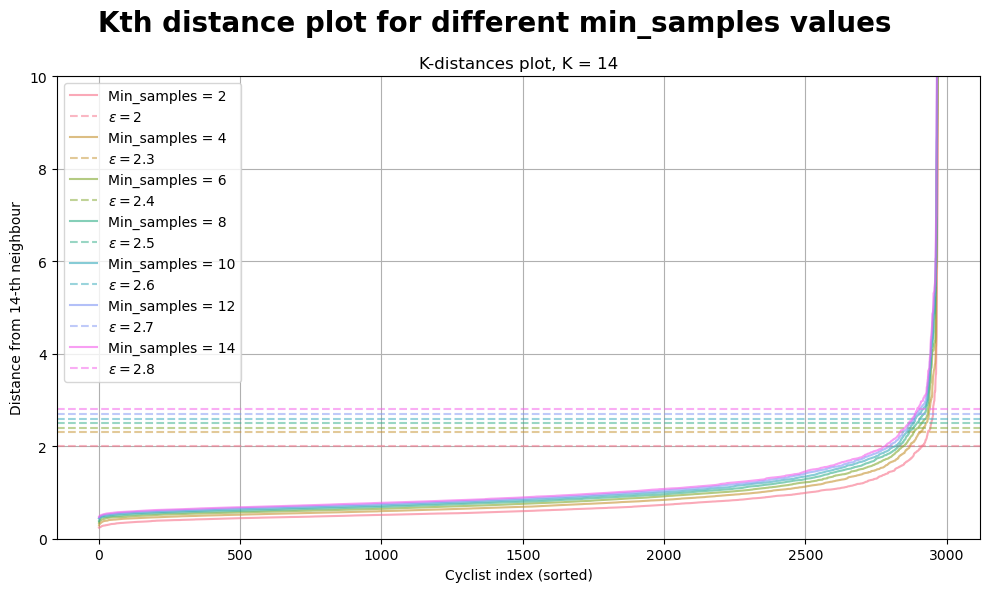

In [27]:
ylim = 10

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Kth distance plot for different min_samples values', fontsize=20, fontweight='bold')
plt.title(f"Restricted view to distances below {ylim}", fontsize=14)

palette = sns.color_palette("husl", len(min_samples_range))
for i, k in enumerate(min_samples_range):
	plot_kdistances(dist_matrix=dist,
				 	k=k, eps_values=eps_range[i],
					color=palette[i], ax=ax, y_lim=ylim)

plt.tight_layout()
plt.show()

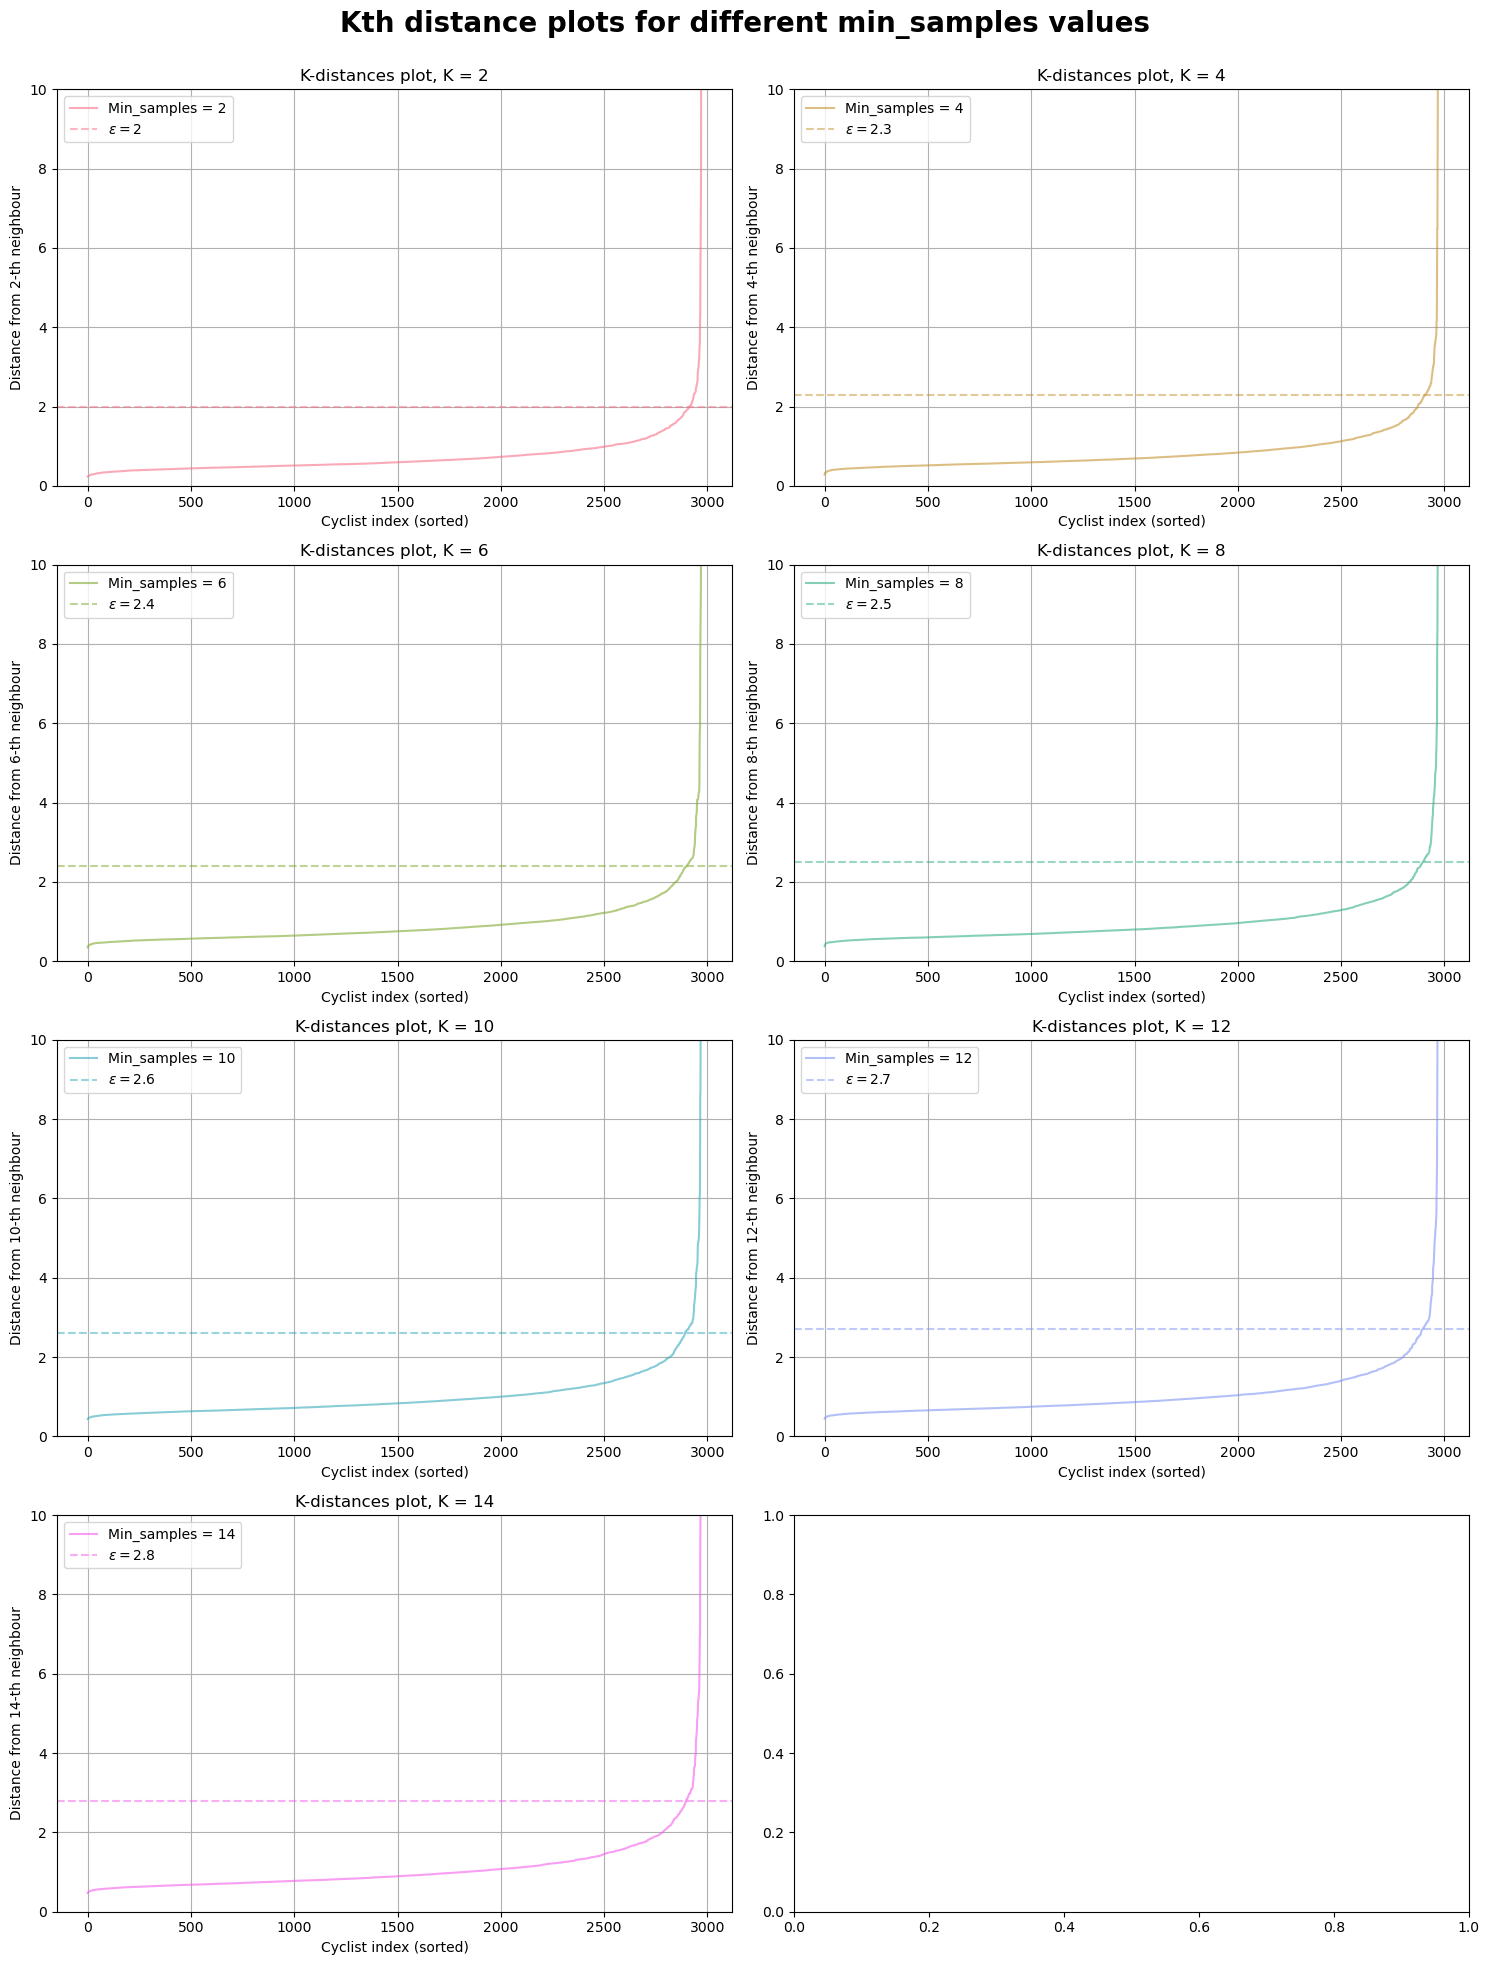

In [28]:
fig, axes = plt.subplots(int(np.ceil(len(min_samples_range) / 2)), 2, figsize=(15, 5 * int(np.ceil(len(min_samples_range) / 2))))
fig.suptitle('Kth distance plots for different min_samples values', fontsize=20, fontweight='bold')
axes = axes.flatten()

palette = sns.color_palette("husl", len(min_samples_range))
for i, (ax, k) in enumerate(zip(axes, min_samples_range)):
	plot_kdistances(dist_matrix=dist,
				 	k=k, ax=ax,
					color=palette[i],
					eps_values=eps_range[i], y_lim=ylim)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

#### Grid Search

Now that the hyperparameters have been defined, let's run the algorithm with the different combinations!

In [29]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 2  , min_samples =   2, n_clusters =  3, n_noise =  36, noise % = 1.21, Silhouette score: 0.680
eps = 2.3, min_samples =   4, n_clusters =  3, n_noise =  30, noise % = 1.01, Silhouette score: 0.630
eps = 2.4, min_samples =   6, n_clusters =  1, n_noise =  29, noise % = 0.98, Silhouette score: 0.741
eps = 2.5, min_samples =   8, n_clusters =  1, n_noise =  32, noise % = 1.08, Silhouette score: 0.734
eps = 2.6, min_samples =  10, n_clusters =  1, n_noise =  32, noise % = 1.08, Silhouette score: 0.734
eps = 2.7, min_samples =  12, n_clusters =  1, n_noise =  32, noise % = 1.08, Silhouette score: 0.733
eps = 2.8, min_samples =  14, n_clusters =  1, n_noise =  32, noise % = 1.08, Silhouette score: 0.734


Same comment as before, but replace the 16 with a 6. We can look at what happened with `min_samples` equal to 2.

**OSS**: As [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation) smartly points out, setting `min_samples=2` is the same as performing hierarchical clustering with the single link metric (aka min link), and cutting the dendrogram at a height equal to the corresponding epsilon value

In [30]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=2_eps=2']
cyclist_clustering_df['cluster'].value_counts()

cluster
 0    2929
-1      36
 1       4
 2       2
Name: count, dtype: int64

In [31]:
if RUN_SLOW_STUFF:
	sns.pairplot(cyclist_clustering_df, hue='cluster', palette='tab10')
	plt.show()

Vabbè dai è ridicolo questo, non lo commento neanche. Vabbè dai diamo un'occhiata...

In [32]:
noisy_df_2 = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'].apply(lambda c: c in [1,2,3,4])].index].drop(columns=['experience_level','cyclist_age'])
noisy_df_2

,_url,name,birth_year,weight,height,nationality,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
992,roger-de-vlaeminck,Roger De Vlaeminck,1947.0,74.0,181.0,Belgium,22.587833,114.0,8465.0,13,74.254386,6.252174,10.815050,18.300479
2266,moreno-argentin,Moreno Argentin,1960.0,66.0,175.0,Italy,21.551020,119.0,6104.0,13,51.294118,39.283333,10.953548,16.330206
2482,freddy-maertens,Freddy Maertens,1952.0,65.0,174.0,Belgium,21.469150,144.0,7323.0,11,50.854167,12.000000,10.617251,17.841251
2497,fabian-cancellara,Fabian Cancellara,1981.0,80.0,186.0,Switzerland,23.124061,577.0,9207.0,15,15.956672,76.070588,11.151492,9.153238
4873,tom-boonen,Tom Boonen,1980.0,82.0,192.0,Belgium,22.243924,446.0,8963.0,16,20.096413,67.384956,11.096346,10.956448
5360,jan-raas,Jan Raas,1952.0,72.0,176.0,Netherlands,23.243802,137.0,7145.0,13,52.153285,25.850000,10.720739,15.662663


The following cyclists had been found in the previous analysis (but in the previous attempts they were noisy points)

In [33]:
noisy_df_2.loc[noisy_df_2['_url'].isin(noisy_df['_url'])]

,_url,name,birth_year,weight,height,nationality,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
992,roger-de-vlaeminck,Roger De Vlaeminck,1947.0,74.0,181.0,Belgium,22.587833,114.0,8465.0,13,74.254386,6.252174,10.815050,18.300479
2266,moreno-argentin,Moreno Argentin,1960.0,66.0,175.0,Italy,21.551020,119.0,6104.0,13,51.294118,39.283333,10.953548,16.330206
2482,freddy-maertens,Freddy Maertens,1952.0,65.0,174.0,Belgium,21.469150,144.0,7323.0,11,50.854167,12.000000,10.617251,17.841251
2497,fabian-cancellara,Fabian Cancellara,1981.0,80.0,186.0,Switzerland,23.124061,577.0,9207.0,15,15.956672,76.070588,11.151492,9.153238
4873,tom-boonen,Tom Boonen,1980.0,82.0,192.0,Belgium,22.243924,446.0,8963.0,16,20.096413,67.384956,11.096346,10.956448
5360,jan-raas,Jan Raas,1952.0,72.0,176.0,Netherlands,23.243802,137.0,7145.0,13,52.153285,25.850000,10.720739,15.662663


In [34]:
noisy_df_2.describe()

,birth_year,weight,height,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1962.000000,73.166667,180.666667,22.369965,256.166667,7867.833333,13.500000,44.101507,37.806842,10.892404,14.707381
std,14.926487,6.997619,7.146095,0.758649,202.375311,1206.632076,1.760682,22.089525,28.795192,0.211480,3.773476
min,1947.000000,65.000000,174.000000,21.469150,114.000000,6104.000000,11.000000,15.956672,6.252174,10.617251,9.153238
25%,1952.000000,67.500000,175.250000,21.724246,123.500000,7189.500000,13.000000,27.785851,15.462500,10.744317,12.133001
50%,1956.000000,73.000000,178.500000,22.415878,140.500000,7894.000000,13.000000,51.074142,32.566667,10.884299,15.996435
75%,1975.000000,78.500000,184.750000,22.990004,370.500000,8838.500000,14.500000,51.938493,60.359550,11.060646,17.463489
max,1981.000000,82.000000,192.000000,23.243802,577.000000,9207.000000,16.000000,74.254386,76.070588,11.151492,18.300479


Half of the values in the smaller clusters were noisy points before... I'd say that it's not worth wasting time interpreting the results. 

What happened is that by increasing the `min_samples` value, the points that now are in a cluster are flagged as noise because they don't have enough neighbours.

In [35]:
cyclist_clustering_df.drop(columns=['cluster'], inplace=True)

### Attempt 3

As a third attempt, we try to be even more conservative with the `eps`, and consider less neighbours. In fact it was obvious by observing where I put the threshold that I would have had very few noise points (duh!)

#### Hyperparameters range

In [36]:
MIN_SAMPLES_TRIALS = 10
distance_range = ['euclidean']
min_samples_range = range(2,MIN_SAMPLES_TRIALS)
eps_range = [[1.4], [1.6], [1.6], [1.7], [1.7], [1.8], [1.9], [2]]

print(f"Values for min_samples: {[x for x in min_samples_range]}")

Values for min_samples: [2, 3, 4, 5, 6, 7, 8, 9]


Let's look for the $\epsilon$ values (we can keep some from before)

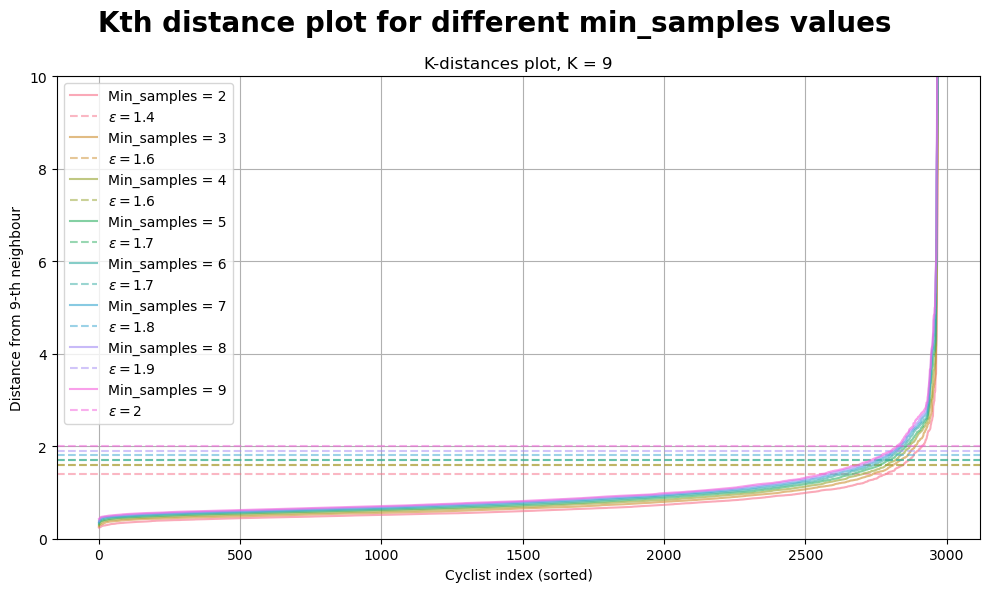

In [37]:
ylim = 10

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Kth distance plot for different min_samples values', fontsize=20, fontweight='bold')
plt.title(f"Restricted view to distances below {ylim}", fontsize=14)

palette = sns.color_palette("husl", len(min_samples_range))
for i, k in enumerate(min_samples_range):
	plot_kdistances(dist_matrix=dist,
				 	k=k, eps_values=eps_range[i],
					color=palette[i], ax=ax, y_lim=ylim)

plt.tight_layout()
plt.show()

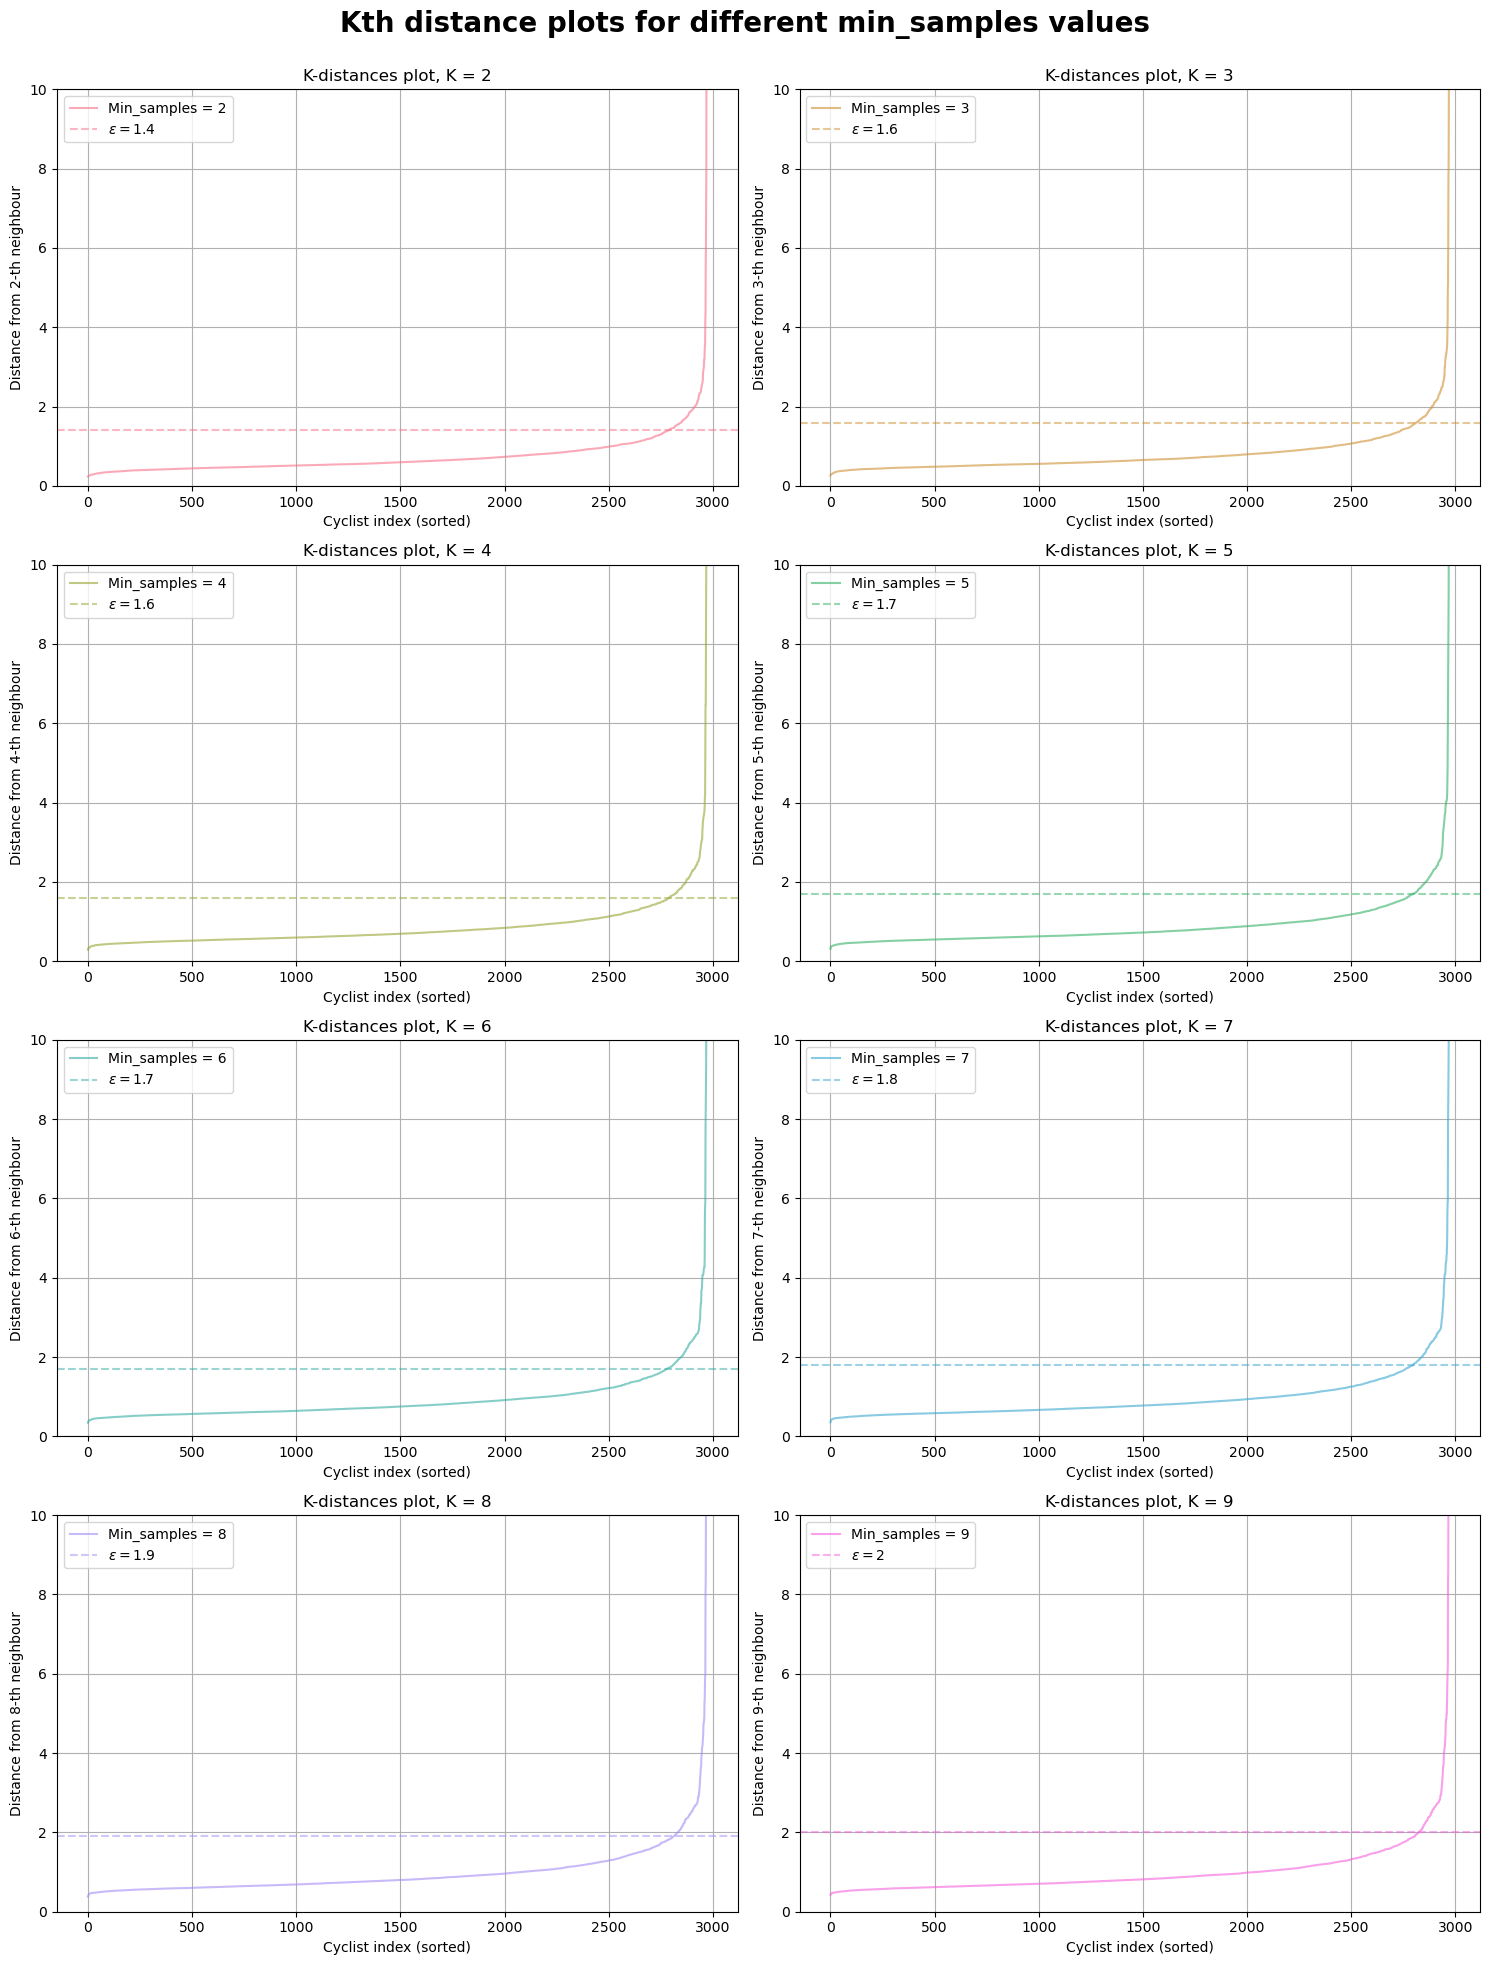

In [38]:
fig, axes = plt.subplots(int(np.ceil(len(min_samples_range) / 2)), 2, figsize=(15, 5 * int(np.ceil(len(min_samples_range) / 2))))
fig.suptitle('Kth distance plots for different min_samples values', fontsize=20, fontweight='bold')
axes = axes.flatten()

palette = sns.color_palette("husl", len(min_samples_range))
for i, (ax, k) in enumerate(zip(axes, min_samples_range)):
	plot_kdistances(dist_matrix=dist,
				 	k=k, ax=ax,
					color=palette[i],
					eps_values=eps_range[i], y_lim=ylim)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

#### Grid Search

Now that the hyperparameters have been defined, let's run the algorithm with the different combinations!

In [39]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 1.4, min_samples =   2, n_clusters = 15, n_noise = 117, noise % = 3.94, Silhouette score: 0.085
eps = 1.6, min_samples =   3, n_clusters =  5, n_noise =  95, noise % = 3.20, Silhouette score: 0.434
eps = 1.6, min_samples =   4, n_clusters =  5, n_noise = 103, noise % = 3.47, Silhouette score: 0.303
eps = 1.7, min_samples =   5, n_clusters =  5, n_noise =  88, noise % = 2.96, Silhouette score: 0.417
eps = 1.7, min_samples =   6, n_clusters =  1, n_noise = 113, noise % = 3.80, Silhouette score: 0.591
eps = 1.8, min_samples =   7, n_clusters =  1, n_noise = 101, noise % = 3.40, Silhouette score: 0.607
eps = 1.9, min_samples =   8, n_clusters =  1, n_noise =  92, noise % = 3.10, Silhouette score: 0.620
eps = 2  , min_samples =   9, n_clusters =  1, n_noise =  71, noise % = 2.39, Silhouette score: 0.648


Ok, this is way more interesting. It looks like, in this setup, DBSCAN is very sensible to the `min_samples` hyperparameter.

##### `min_samples` = 2

In [ ]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=2_eps=1.4']
print(cyclist_clustering_df['cluster'].value_counts())
print(f"Noise points are {100*sum(cyclist_clustering_df['cluster'] == -1)/cyclist_clustering_df.shape[0]:2.2f}% of the total")

cluster
 0     2816
-1      117
 1        6
 10       4
 13       4
 4        3
 11       3
 2        2
 3        2
 5        2
 6        2
 7        2
 8        2
 9        2
 12       2
 14       2
Name: count, dtype: int64
Noise points are 3.94% of the total


With a lower `eps` value we get a different result, but it looks like the same as before, conceptually. Clusters with 4 or less points don't make sense, they're "ready to become noise". It's just that a lower `eps` value combined with an extremely low `min_points` value makes everything look like a cluster!

Also, w.r.t. the previous `min_points = 2` case we have more noise points

In [41]:
if RUN_SLOW_STUFF:
	sns.pairplot(cyclist_clustering_df, hue='cluster', palette='tab10')
	plt.show()

Yet, is nice to observe that the noise points, at least visually, make sense. 

The silhouette score is absolute garbage. At this point, it was better to have a single cluster and the noise points!

For now, reducing the `eps` seems to have, as a consequence, to worsen the results: introduce nonsensical clusters that are noise points.  

In [ ]:
noisy_df = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'] == -1].index].drop(columns=['experience_level','cyclist_age'])
noisy_df.describe()

,birth_year,weight,height,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
count,117.000000,110.000000,117.000000,110.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,1973.512821,70.418182,177.700855,22.057135,255.572650,3882.495726,4.358974,19.138153,60.064244,11.019525,12.366357
std,16.848522,7.042964,8.519010,1.400050,268.780622,4048.846672,5.825718,21.521537,43.768249,0.589511,7.622372
min,1942.000000,57.000000,154.000000,18.826793,1.000000,0.000000,0.000000,0.000000,3.000000,9.562050,0.303011
25%,1960.000000,65.000000,172.000000,21.052770,7.000000,45.000000,0.000000,6.504931,31.053254,10.671875,9.058281
50%,1974.000000,70.000000,178.000000,22.046566,166.000000,3217.000000,2.000000,14.806667,48.640898,11.000983,10.949100
75%,1987.000000,75.000000,183.000000,22.838972,447.000000,6350.000000,6.000000,21.422287,78.888889,11.190592,13.317610
max,2002.000000,88.000000,204.000000,25.661152,959.000000,18726.000000,29.000000,150.000000,205.000000,13.021981,70.167143


I've wasted too much time and space commenting on nonsensical clusterings

In [43]:
cyclist_clustering_df.drop(columns=['cluster'], inplace=True)

##### `min_samples` = 8

In [44]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=8_eps=1.9']
print(cyclist_clustering_df['cluster'].value_counts())
print(f"Noise points are {100*sum(cyclist_clustering_df['cluster'] == -1)/cyclist_clustering_df.shape[0]:2.2f}% of the total")

cluster
 0    2879
-1      92
Name: count, dtype: int64
Noise points are 3.10% of the total


In [45]:
if RUN_SLOW_STUFF:
	sns.pairplot(cyclist_clustering_df, hue='cluster', palette='tab10')
	plt.show()

What can I tell you??

In [46]:
noisy_df_2 = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'] == -1].index].drop(columns=['experience_level','cyclist_age'])
noisy_df_2.describe()

,birth_year,weight,height,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
count,92.000000,89.000000,92.000000,89.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1970.989130,69.966292,177.543478,22.061947,265.054348,5012.423913,6.021739,24.065127,55.098236,11.222186,13.971233
std,16.382445,6.359405,6.557293,1.291278,247.412960,4209.526319,6.224691,22.468513,43.635575,0.691195,7.934495
min,1942.000000,57.000000,157.000000,19.470778,1.000000,0.000000,0.000000,0.000000,3.000000,9.803852,0.303011
25%,1959.750000,65.000000,174.000000,21.224490,8.500000,351.000000,0.000000,12.058535,27.001471,10.849655,10.883543
50%,1971.000000,70.000000,178.000000,21.887076,245.000000,5397.000000,5.000000,17.958604,42.348725,11.065026,12.132998
75%,1984.000000,74.000000,181.000000,22.724403,446.250000,7185.000000,9.000000,26.356669,64.181854,11.375289,14.323023
max,2002.000000,83.000000,192.000000,25.308642,942.000000,18726.000000,29.000000,150.000000,205.000000,13.021981,70.167143


In [47]:
noisy_df_2.loc[noisy_df_2['_url'].isin(noisy_df['_url'])]

,_url,name,birth_year,weight,height,nationality,bmi,race_count,total_points,victories_by_points,avg_points_per_race,average_position,avg_speed_cyclist,mean_stamina_index
87,michael-matthews,Michael Matthews,1990.0,72.0,178.0,Australia,22.724403,485.0,8044.0,6,16.585567,53.959514,11.151429,11.369218
109,tadej-pogacar,Tadej Pogačar,1998.0,66.0,176.0,Slovenia,21.306818,166.0,5980.0,12,36.024096,14.295858,11.565382,17.392149
200,maurizio-fondriest,Maurizio Fondriest,1965.0,70.0,182.0,Italy,21.132713,246.0,5393.0,4,21.922764,34.692000,11.086141,10.940910
225,alain-vasseur,Alain Vasseur,1948.0,67.0,175.0,France,21.877551,5.0,162.0,0,32.400000,21.000000,10.719641,20.030184
226,jean-pierre-monsere,Jean-Pierre Monseré,1948.0,66.0,178.0,Belgium,20.830703,7.0,559.0,1,79.857143,9.714286,11.149136,70.167143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5716,bernard-hinault,Bernard Hinault,1954.0,62.0,174.0,France,20.478267,266.0,9917.0,12,37.281955,17.139706,10.519414,13.611124
5851,remco-evenepoel,Remco Evenepoel,2000.0,61.0,171.0,Belgium,20.861120,106.0,2785.0,8,26.273585,27.733945,11.605714,13.178025
5921,alessandro-petacchi,Alessandro Petacchi,1974.0,70.0,185.0,Italy,20.452885,672.0,9264.0,11,13.785714,63.816474,10.916310,12.041895
5986,claudio-chiappucci,Claudio Chiappucci,1963.0,67.0,172.0,Italy,22.647377,413.0,6385.0,3,15.460048,26.873810,10.919392,11.224122


Most of the noise points in this case were noise points also before. Given these circumstances, basically we're doing outlier detection, not clustering! It's difficult to say where we've struck the balance between noisy points (outliers) and non-noisy points

In [48]:
cyclist_clustering_df.drop(columns=['cluster'], inplace=True)

### Attempt 4

It looks like the data is really cluttered, all the datapoints are really close. 

Here's a thought-provoking idea: *what if we didn't have enough dimensions* for the data values to vary? That is, for the datapoints to "distinguish themselves in a meaningful way"? Wow, big thought provocations right there! But we can't do much about it...

Another thing we could do is to consider a subset of the data. 

... Well, by exploring the data we noticed that the `victories_by_points` feature is kind of "off": less than 6% of the cyclists in the (overall) dataset have a value higher than 1 (so, 1 or more) for this feature.

So basically having a nonzero value for this feature makes a cyclist an "outlier", thus it makes sense that the "strong cyclists" are detected as "noise points". Albeit informative, this is not a deep result.

Let's repeat the clustering without the `victories_by_points` feature

In [49]:
old_cyclist_clustering_df = cyclist_clustering_df.copy()
cyclist_clustering_df.drop(columns=['victories_by_points'], inplace=True)
cyc_clustering_normalized_df.drop(columns=['victories_by_points'], inplace=True)

#### Hyperparameters range

In [50]:
MIN_SAMPLES_TRIALS = 8
distance_range = ['euclidean']
min_samples_range = [2*x for x in range(1,MIN_SAMPLES_TRIALS)]
eps_range = [[1.1,1.3], [1.4,1.6], [1.5,1.7], [1.7,1.9], [1.7,1.9], [1.8,2], [1.9,2.1]]

print(f"Values for min_samples: {min_samples_range}")

Values for min_samples: [2, 4, 6, 8, 10, 12, 14]


Before looking for the best $\epsilon$ value, we have to recompute the distances! Because the datapoinst have changed.

In [ ]:
dist = pdist(cyc_clustering_normalized_df, metric=distance_range[0]) # pairwise distances
print(f"dist.shape = {dist.shape}")
dist = squareform(dist) # convert to a distance matrix
print(f"dist.shape = {dist.shape}, cyc_clustering_normalized_df.shape[0] = {cyc_clustering_normalized_df.shape[0]}")

dist.shape = (4411935,)
dist.shape = (2971, 2971), cyc_clustering_normalized_df.shape[0] = 2971


Now we can look for the $\epsilon$ value

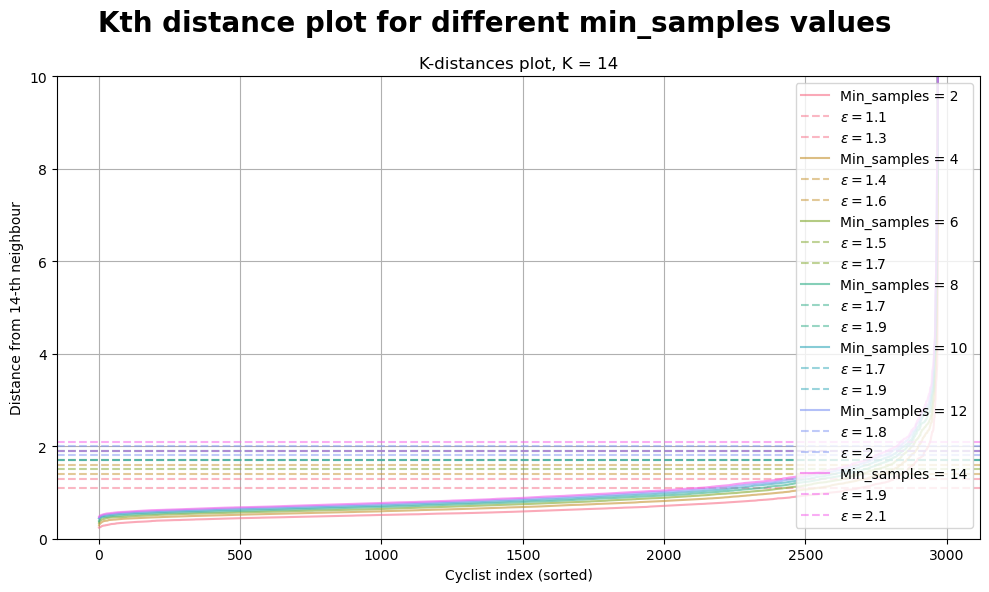

In [52]:
ylim = 10

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Kth distance plot for different min_samples values', fontsize=20, fontweight='bold')
plt.title(f"Restricted view to distances below {ylim}", fontsize=14)

palette = sns.color_palette("husl", len(min_samples_range))
for i, k in enumerate(min_samples_range):
	plot_kdistances(dist_matrix=dist,
				 	k=k, eps_values=eps_range[i],
					color=palette[i], ax=ax, y_lim=ylim)

plt.tight_layout()
plt.show()

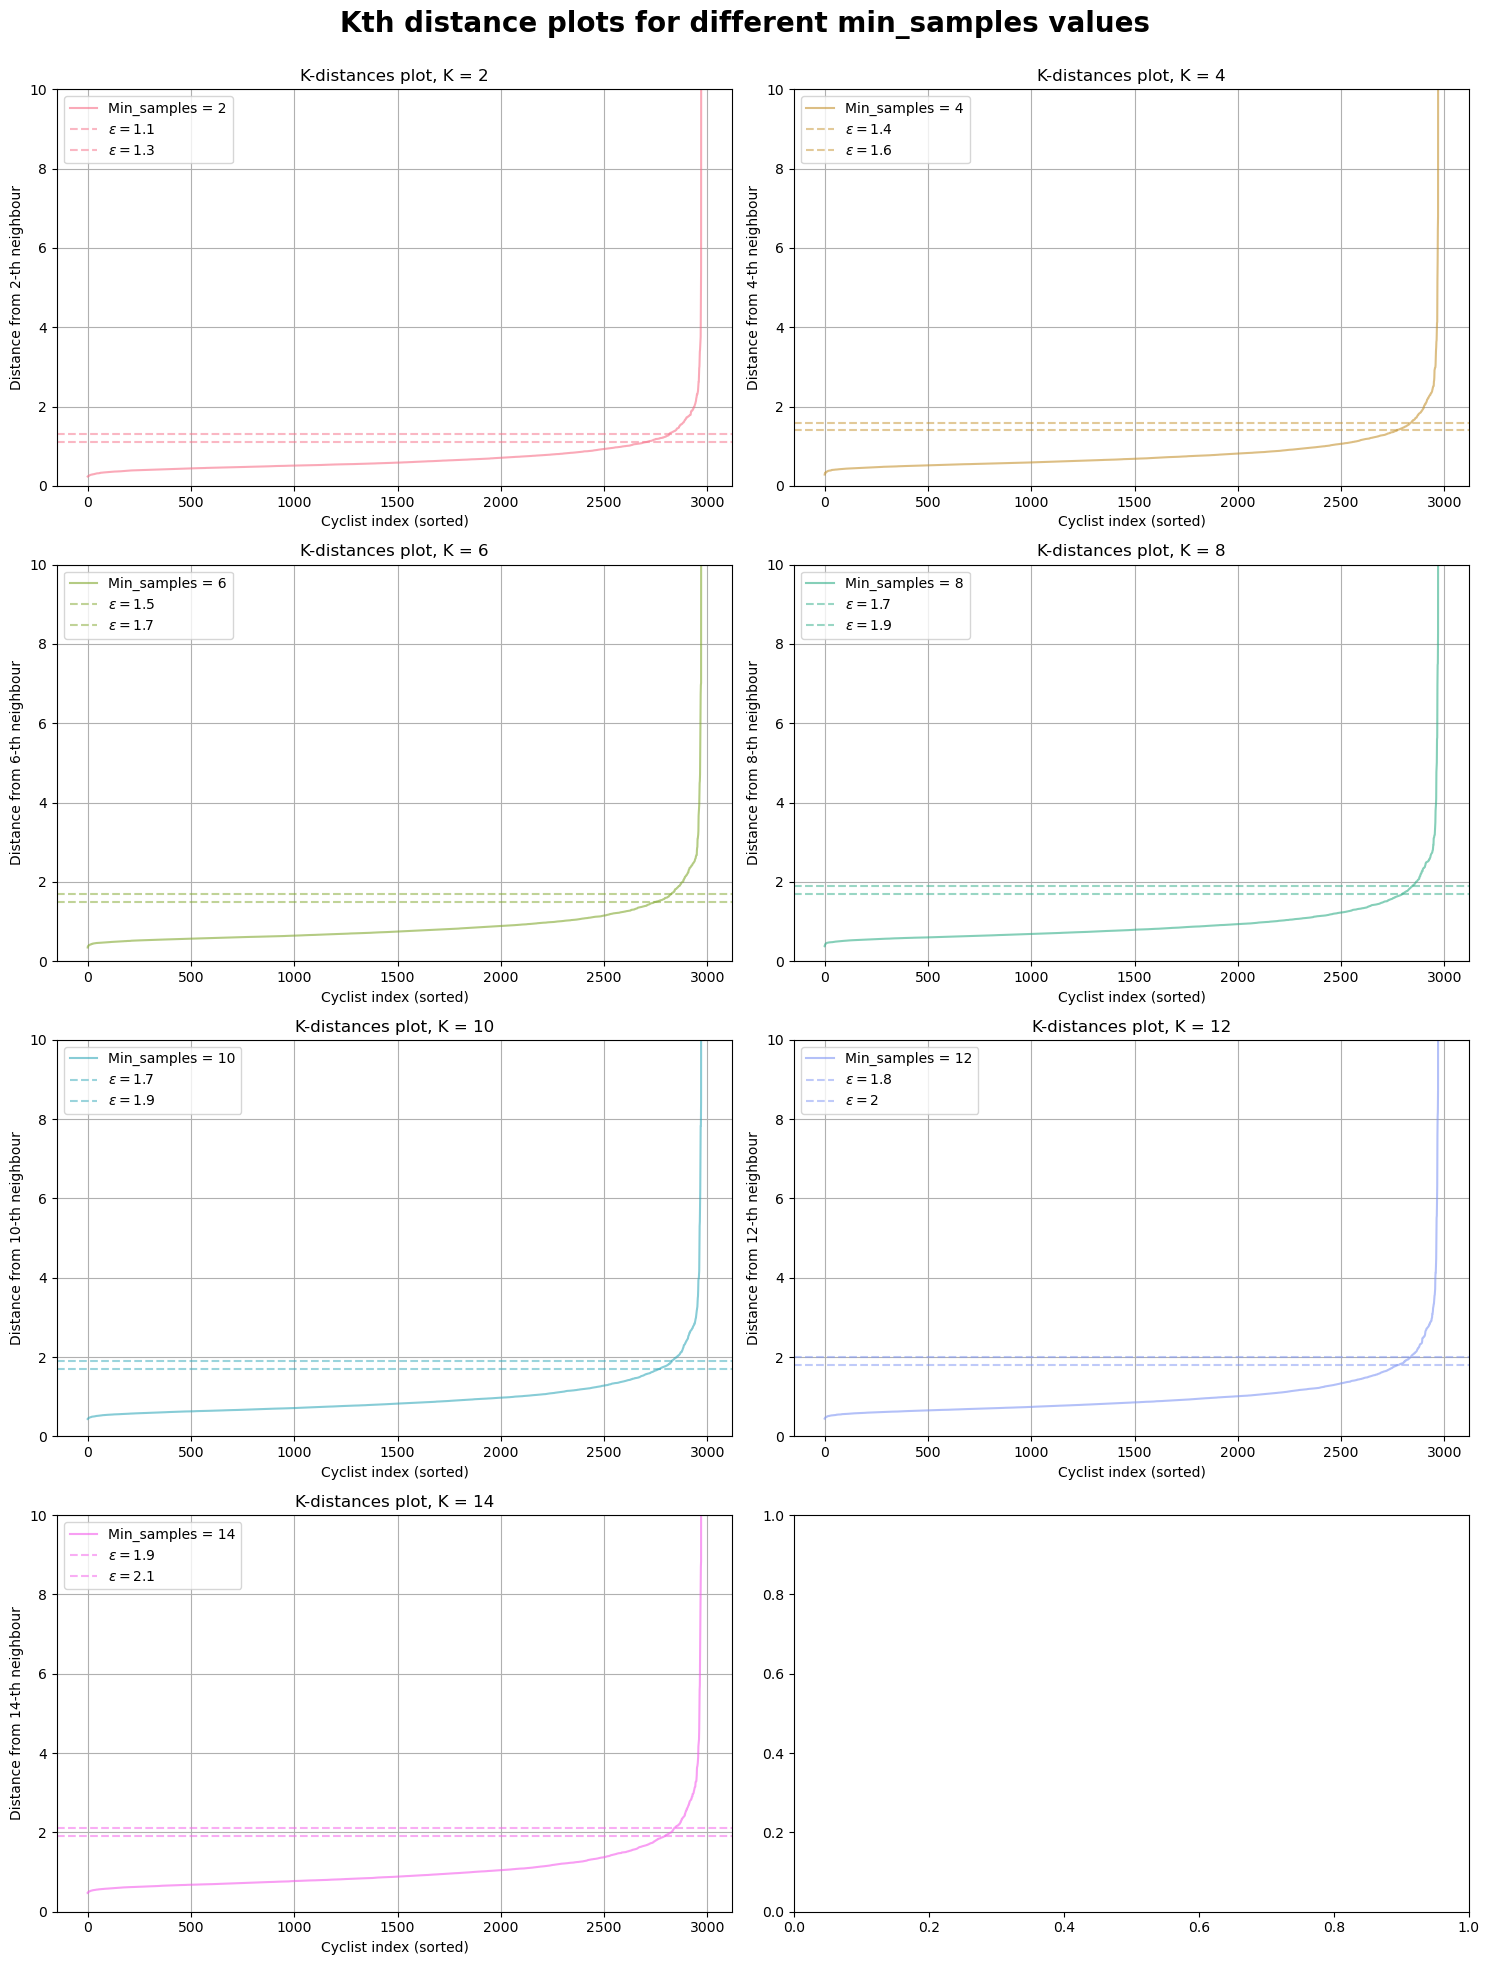

In [53]:
fig, axes = plt.subplots(int(np.ceil(len(min_samples_range) / 2)), 2, figsize=(15, 5 * int(np.ceil(len(min_samples_range) / 2))))
fig.suptitle('Kth distance plots for different min_samples values', fontsize=20, fontweight='bold')
axes = axes.flatten()

palette = sns.color_palette("husl", len(min_samples_range))
for i, (ax, k) in enumerate(zip(axes, min_samples_range)):
	plot_kdistances(dist_matrix=dist,
				 	k=k, ax=ax,
					color=palette[i],
					eps_values=eps_range[i], y_lim=ylim)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

These k-distances plot seem to never change, do they?

#### Grid Search

Now that the hyperparameters have been defined, let's run the algorithm with the different combinations!

In [54]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 1.1, min_samples =   2, n_clusters = 24, n_noise = 172, noise % = 5.79, Silhouette score: 0.000
eps = 1.3, min_samples =   2, n_clusters = 11, n_noise = 103, noise % = 3.47, Silhouette score: 0.117
eps = 1.4, min_samples =   4, n_clusters =  5, n_noise =  98, noise % = 3.30, Silhouette score: 0.147
eps = 1.6, min_samples =   4, n_clusters =  3, n_noise =  72, noise % = 2.42, Silhouette score: 0.335
eps = 1.5, min_samples =   6, n_clusters =  1, n_noise = 103, noise % = 3.47, Silhouette score: 0.525
eps = 1.7, min_samples =   6, n_clusters =  1, n_noise =  78, noise % = 2.63, Silhouette score: 0.560
eps = 1.7, min_samples =   8, n_clusters =  1, n_noise =  81, noise % = 2.73, Silhouette score: 0.558
eps = 1.9, min_samples =   8, n_clusters =  1, n_noise =  61, noise % = 2.05, Silhouette score: 0.592
eps = 1.7, min_samples =  10, n_clusters =  1, n_noise =  94, noise % = 3.16, Silhouette score: 0.542
eps = 1.9, min_samples =  10, n_clusters =  1, n_noise =  61, noise % = 2.05, Silh

The algorithm is very sensitive to `eps`. I mean, by nudging it a little we can include a lot more points! This is espected.

Again, with `min_samples = 2` - which is an unfortunate choice for the value of this hyperparameter - we have a lot of clusters (nonsensical, uninformative), but when we reach 6 we get a single cluster. Have we struck the correct balance with 4? 

#### `min_samples` = 4

In [ ]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=4_eps=1.6']
print(cyclist_clustering_df['cluster'].value_counts())
print(f"Noise points are {100*sum(cyclist_clustering_df['cluster'] == -1)/cyclist_clustering_df.shape[0]:2.2f}% of the total")

cluster
 0    2889
-1      72
 2       6
 1       4
Name: count, dtype: int64
Noise points are 2.42% of the total


The additional clusters are kind of empty, not gonna lie. I doubt that there's any profound "meaning" to them...

In [56]:
if RUN_SLOW_STUFF:	
	sns.pairplot(cyclist_clustering_df, hue='cluster', palette='tab10')
	plt.show()

In [57]:
noisy_df = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'] == -1].index].drop(columns=['experience_level','cyclist_age'])
comparing_df = cyclist_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'].apply(lambda c: c in [1,2,3,4])].index].drop(columns=['experience_level','cyclist_age'])
comparing_df_2 = cyclist_clustering_df.loc[cyclist_clustering_df[cyclist_clustering_df['cluster'].apply(lambda c: c in [1,2,3,4])].index]#.drop(columns=['experience_level','cyclist_age'])

In [ ]:
comparing_df['victories_by_points'].unique()

array([0])

In [ ]:
comparing_df_2

,birth_year,height,race_count,total_points,average_position,avg_speed_cyclist,mean_stamina_index,cluster
338,1981.0,183.0,1.0,15.0,109.0,12.870760,11.807195,2
1728,1991.0,187.0,1.0,5.0,177.0,11.199450,11.145784,1
1737,1975.0,179.0,1.0,15.0,125.0,12.690234,11.569134,2
2076,1973.0,174.0,1.0,15.0,147.0,12.690234,11.485466,2
2195,1985.0,183.0,1.0,15.0,148.0,12.690234,11.482250,2
3261,1995.0,192.0,1.0,5.0,166.0,11.516998,11.355817,1
3441,1988.0,188.0,1.0,0.0,205.0,11.423221,9.058281,1
5158,1993.0,184.0,2.0,10.0,175.5,10.818675,10.757148,1
5188,1977.0,176.0,1.0,15.0,114.0,12.823724,11.242894,2
5487,1976.0,168.0,1.0,15.0,115.0,12.690234,11.617656,2


Clusters 1 and 2 have cyclists with zero values of `victories_by_points`

In [ ]:
noisy_df['victories_by_points'].value_counts()

victories_by_points
0     37
10     4
16     4
6      3
9      3
4      2
12     2
1      2
11     2
8      2
21     1
14     1
13     1
29     1
27     1
15     1
19     1
2      1
3      1
7      1
5      1
Name: count, dtype: int64

Whereas, many noise points have a nonzero value for `victories_by_points`. But they're not all here!

Removing the `victories_by_points` feature didn't help us create a higher number of clusters.

In [61]:
cyclist_clustering_df.drop(columns=['cluster'], inplace=True)

### Attempt 5

At this point the game becomes: "Assuming the fact that the cyclists with more than 0 victories by points are "outliers", can DBSCAN detect them, without using the `victories_by_points` feature?

Given what we've seen in the `data_understanding_transformation` notebook (cfr the 3D plots), I expect the answer to be a resounding "Yes". In that notebook we've seen that outliers with a small value for `average_position` also tend to have nonzero values for `victories_by_points`.

In [ ]:
nonzero_victories_by_points = sum(old_cyclist_clustering_df['victories_by_points'] > 0)
print(f"We aim at finding {nonzero_victories_by_points} noise points, i.e. {old_cyclist_clustering_df.shape[0] - nonzero_victories_by_points} core or border points")

We aim at finding 280 noise points, i.e. 2691 core or border points


#### Hyperparameters range

We try out different values for `eps`. The elbow method is fine and all, but we can go directly for the throat! Or try different $\epsilon$ values

In [ ]:
MIN_SAMPLES_TRIALS = 9
distance_range = ['euclidean']
min_samples_range = [2*x for x in range(2,MIN_SAMPLES_TRIALS)]
eps_range = [[1.2, 1.4, 1.6], [1.3, 1.5, 1.7], [1.5, 1.7, 1.9], 
			 [1.5, 1.7, 1.9], [1.6, 1.8, 2], [1.7, 1.9, 2.1], [1.8, 2, 2.2]]

print(f"Values for min_samples: {min_samples_range}")

Values for min_samples: [4, 6, 8, 10, 12, 14, 16]


#### Grid Search

Now that the hyperparameters have been defined, let's run the algorithm with the different combinations!

In [64]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 1.2, min_samples =   4, n_clusters =  6, n_noise = 171, noise % = 5.76, Silhouette score: 0.092
eps = 1.4, min_samples =   4, n_clusters =  5, n_noise =  98, noise % = 3.30, Silhouette score: 0.147
eps = 1.6, min_samples =   4, n_clusters =  3, n_noise =  72, noise % = 2.42, Silhouette score: 0.335
eps = 1.3, min_samples =   6, n_clusters =  3, n_noise = 163, noise % = 5.49, Silhouette score: 0.386
eps = 1.5, min_samples =   6, n_clusters =  1, n_noise = 103, noise % = 3.47, Silhouette score: 0.525
eps = 1.7, min_samples =   6, n_clusters =  1, n_noise =  78, noise % = 2.63, Silhouette score: 0.560
eps = 1.5, min_samples =   8, n_clusters =  1, n_noise = 124, noise % = 4.17, Silhouette score: 0.510
eps = 1.7, min_samples =   8, n_clusters =  1, n_noise =  81, noise % = 2.73, Silhouette score: 0.558
eps = 1.9, min_samples =   8, n_clusters =  1, n_noise =  61, noise % = 2.05, Silhouette score: 0.592
eps = 1.5, min_samples =  10, n_clusters =  2, n_noise = 131, noise % = 4.41, Silh

Intuitively I say that we can consider more neighbours in a smaller radius. Push it to the limit!

In [65]:
MIN_SAMPLES_TRIALS = 9
distance_range = ['euclidean']
min_samples_range = [4*x for x in range(2,MIN_SAMPLES_TRIALS)]
eps_range = [[1.5, 1.7, 1.9], [1.6, 1.8, 2], [1.8, 2, 2.2], 
			 [1.3, 1.7, 2.1], [1.4, 1.8, 2.2], [1.5, 1.9, 2.3], [1.7, 2.1, 2.4]]

print(f"Values for min_samples: {min_samples_range}")

Values for min_samples: [8, 12, 16, 20, 24, 28, 32]


In [66]:
cluster_labels_dict, dbscans_dict, silhouettes_dict = DBSCAN_grid_search(cyc_clustering_normalized_df, 
																		 min_samples_range, 
																		 eps_range, 
																		 distance_range[0])

eps = 1.5, min_samples =   8, n_clusters =  1, n_noise = 124, noise % = 4.17, Silhouette score: 0.510
eps = 1.7, min_samples =   8, n_clusters =  1, n_noise =  81, noise % = 2.73, Silhouette score: 0.558
eps = 1.9, min_samples =   8, n_clusters =  1, n_noise =  61, noise % = 2.05, Silhouette score: 0.592
eps = 1.6, min_samples =  12, n_clusters =  1, n_noise = 121, noise % = 4.07, Silhouette score: 0.513
eps = 1.8, min_samples =  12, n_clusters =  1, n_noise =  82, noise % = 2.76, Silhouette score: 0.559
eps = 2  , min_samples =  12, n_clusters =  1, n_noise =  52, noise % = 1.75, Silhouette score: 0.611
eps = 1.8, min_samples =  16, n_clusters =  1, n_noise =  93, noise % = 3.13, Silhouette score: 0.549
eps = 2  , min_samples =  16, n_clusters =  1, n_noise =  60, noise % = 2.02, Silhouette score: 0.595
eps = 2.2, min_samples =  16, n_clusters =  1, n_noise =  46, noise % = 1.55, Silhouette score: 0.625
eps = 1.3, min_samples =  20, n_clusters =  1, n_noise = 313, noise % = 10.54, Sil

Let's check one of them

In [67]:
cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=24_eps=1.4']
print(cyclist_clustering_df['cluster'].value_counts())
print(f"Noise points are {100*sum(cyclist_clustering_df['cluster'] == -1)/old_cyclist_clustering_df.shape[0]:2.2f}% of the total")

cluster
 0    2697
-1     274
Name: count, dtype: int64
Noise points are 9.22% of the total


In [68]:
sum(old_cyclist_clustering_df['victories_by_points'] > 0)

280

Let's see if we've struck gold

In [69]:
from sklearn.metrics import confusion_matrix

old_cyclist_clustering_df['cluster'] = cluster_labels_dict['min_samples=24_eps=1.4']

# True positives: noise points with more than 0 victories by points
# False positives: core or border points with more than 0 victories by points
# True negatives: core or border points with 0 victories by points
# False negatives: noise points with 0 victories by points
tn, fp, fn, tp = confusion_matrix(y_true=(old_cyclist_clustering_df['victories_by_points'] > 0), 
				 							y_pred = old_cyclist_clustering_df['cluster'].apply(lambda c: c == -1)).ravel()

print(f"Confusion Matrix:\n")
print(f"\t\t\tPredicted Noise pts. | Predicted Non-Noise pts.")
print(f"Actual Outliers\t\t\t{tp:<10}\t\t{fn:<10}")
print(f"Actual Non-Outliers\t\t{fp:<10}\t\t{tn:<10}")

Confusion Matrix:

			Predicted Noise pts. | Predicted Non-Noise pts.
Actual Outliers			108       		172       
Actual Non-Outliers		166       		2525      


The 274 predictions are split across true and false positives, with 108 true positives (i.e. datapoints with a nonzero value for `victories_by_points` that are identified as noise points) and 166 false positives (i.e. datapoints with a nonzero value for `victories_by_points` that are in the only cluster that we have).

We have a confusion matrix, we can compute precision, recall and F1 score. The one that actually makes more sense in this context in my opinion is the recall, as it tells us the portion of outliers that have actually been detected as outliers. To me it makes more sense conceptually, because I chose this configuration of hyperparameters because the n° of noise points it returned closely matched the number of "outliers" in the data. But I know that this is debateable, as it is debateable to see how a clustering algorithm does in terms of classification

In [70]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true=(old_cyclist_clustering_df['victories_by_points'] > 0),
														   y_pred=old_cyclist_clustering_df['cluster'].apply(lambda c: c == -1))

print(f"Precision: {precision[1]:.3f}")
print(f"Recall: {recall[1]:.3f}")
print(f"F1-score: {f1[1]:.3f}")

Precision: 0.394
Recall: 0.386
F1-score: 0.390


They're both terrible

## Races clustering

Let's move on to races

### Choosing the data, dropping columns

In [71]:
races_df.dtypes

_url                        object
name                        object
stage                       object
stage_type                  object
points                     float64
uci_points                 float64
length                     float64
climb_total                float64
profile                    float64
startlist_quality            int64
date                        object
position                     int64
cyclist                     object
cyclist_age                float64
is_tarmac                     bool
delta                      float64
time                        object
time_seconds                 int64
average_speed              float64
steepness                  float64
season                       int64
is_staged                     bool
race_country                object
norm_points                float64
age_performance_index      float64
quality_adjusted_points    float64
normalized_length          float64
normalized_quality         float64
normalized_steepness

The dataframe has a lot of columns!

This time I start with a narrower analysis, also following the approach of the other NetRiders.

In [77]:
# Remove all the non-numeric columns
columns_to_keep = ['length','climb_total','startlist_quality','average_speed']
races_clustering_df = races_df.copy()[columns_to_keep]
races_clustering_df.dtypes

length               float64
climb_total          float64
startlist_quality      int64
average_speed        float64
dtype: object

We kept few columns. Let's drop the rows with NaN values

In [78]:
races_clustering_df.isna().sum()

length                    0
climb_total          137267
startlist_quality         0
average_speed             0
dtype: int64

In [76]:
initial_count = races_clustering_df.shape[0]
races_clustering_df.dropna(inplace=True)
final_count = races_clustering_df.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {100*(initial_count - final_count) / initial_count:2.2f}%')
print(f'Final shape: {races_clustering_df.shape}')

Dropped 137267 rows with missing values
In percentage: 26.24%
Final shape: (385806, 4)


### Data Normalization

In [79]:
races_clustering_normalizer, races_clustering_normalized = scale_data(races_clustering_df)

races_clustering_normalized_df = pd.DataFrame(races_clustering_normalized).rename(columns={i:col for i,col in enumerate(races_clustering_df.columns)})
races_clustering_normalized_df.head()

,length,climb_total,startlist_quality,average_speed
0,-0.065705,-0.915841,0.388404,0.178813
1,-0.065705,-0.915841,0.388404,0.178813
2,-0.065705,-0.915841,0.388404,0.178813
3,-0.065705,-0.915841,0.388404,0.178813
4,-0.065705,-0.915841,0.388404,0.178813


In [80]:
races_clustering_normalized_df.describe()

,length,climb_total,startlist_quality,average_speed
count,5.230730e+05,3.858060e+05,5.230730e+05,5.230730e+05
mean,8.172139e-17,4.184365e-17,1.556184e-16,-3.369051e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.517008e+00,-1.702124e+00,-2.582136e+00,-5.191981e+00
25%,-2.240502e-01,-7.512873e-01,-6.747644e-01,-5.916779e-01
50%,1.779025e-01,-4.585089e-02,-2.869585e-01,5.883703e-02
75%,5.661523e-01,7.032281e-01,5.282253e-01,6.222430e-01
max,2.613980e+00,3.286012e+00,2.514741e+00,6.528803e+00
